<a href="https://colab.research.google.com/github/ab1pradhan/Deep_learning-Tensorflow/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning
https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import os


# layers API helps to see output of the layers
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  

# model import
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


# Specifying desired input shape
# include_top=False argument, you load a network that doesn't include 
# the classification layers at the top

#  weights = None means we dont want built-in weights
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  

# summary of the model
#pre_trained_model.summary()


--2020-09-07 08:56:50--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  69.1MB/s    in 1.2s    

2020-09-07 08:56:52 (69.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
# all the layers have Names so example we want to se 'mixed7' layer which are 
# output of convolutions of 7x7
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)

# grab this layer and taking to the output of the layer to the DNN
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)


# Dropout removes random nuber of neurons to prevent overfitting 
# Layers can have similar weights and can cause overfitting
# Dropping some can make neighbours neurons not affect each other
# Add a dropout rate of 0.2 i.2 drop 20 precent of neurons

x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [7]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-09-07 09:15:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.13.128, 64.233.167.128, 64.233.166.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  52.5MB/s    in 1.2s    

2020-09-07 09:15:23 (52.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 24s - loss: 0.3361 - accuracy: 0.8555 - val_loss: 0.1095 - val_accuracy: 0.9600
Epoch 2/20
100/100 - 22s - loss: 0.2234 - accuracy: 0.9160 - val_loss: 0.1943 - val_accuracy: 0.9340
Epoch 3/20
100/100 - 22s - loss: 0.2222 - accuracy: 0.9180 - val_loss: 0.1029 - val_accuracy: 0.9680
Epoch 4/20
100/100 - 22s - loss: 0.1866 - accuracy: 0.9300 - val_loss: 0.1396 - val_accuracy: 0.9580
Epoch 5/20
100/100 - 22s - loss: 0.1844 - accuracy: 0.9380 - val_loss: 0.1996 - val_accuracy: 0.9340
Epoch 6/20
100/100 - 22s - loss: 0.1679 - accuracy: 0.9430 - val_loss: 0.1462 - val_accuracy: 0.9530
Epoch 7/20
100/100 - 22s - loss: 0.1903 - accuracy: 0.9355 - val_loss: 0.1691 - val_accuracy: 0.9470
Epoch 8/20
100/100 - 22s - loss: 0.1600 - accuracy: 0.9490 - val_loss: 0.1175 - val_accuracy: 0.9650
Epoch 9/20
100/100 - 22s - loss: 0.1777 - accuracy: 0.9400 - val_loss: 0.1168 - val_accuracy: 0.9660
Epoch 10/20
100/100 - 22s - loss: 0.1672 - accuracy: 0.9445 - val_loss: 0.1378 - val_accura

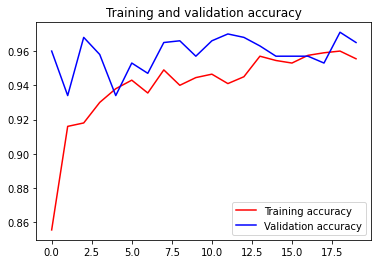

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()